- Full Name: Tran Phi Hung
- Position Application: AI Engineer Intern
- Location: Ho Chi Minh City


## Analysis and research price fluctuation patterns

#### Content:
  - Data Ingestion
  - Data Preprocessing
  - Feature Engineering
  - Modeling
  - Predicting
  - Comment and evaluation model
  - Conclusion
  


#### Data Ingestion
- Import some important dependencies

In [62]:
import os
import sys
import math
import torch
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder
  )
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV
  )
from sklearn.pipeline import Pipeline
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


- Loadding dataset from local storation.

In [63]:
from typing import Optional
class Dataset:
  def __init__(self,
               data_dir: str,
               figsize: set,
               fontsize: int):

    super(Dataset, self).__init__()
    self.data_dir = data_dir # "/content/drive/MyDrive/Datasets/JewelryCompany"
    self.figsize = figsize # (14, 6)
    self.fontsize = fontsize # 18
    self.full_paths = []


  def open_data(self) -> Optional[list]:

    if self.data_dir is None or self.data_dir == "":
      return "Data Folder does not exist.."
    for name_f in os.listdir(self.data_dir):
      full_path = os.path.join(self.data_dir, name_f)
      self.full_paths.append(full_path)
    return self.full_paths

  def merging_data(self, paths_df):
    # merging dataset of all ticker stocks
    df = pd.concat([pd.read_csv(path) for path in paths_df], axis = 0)
    return df

  def show_info(self, df):
    print(f"Show the first 5 lines of the data")
    print(df.head())
    print("-"*50)

    print(f"General info of the data")
    print(df.info())
    print("-"*50)

    print(f"Shape of the data")
    print(df.shape)
    print("-"*50)

    print(f"Description of the data")
    print(df.describe())
    print("-"*50)

    print(f"Number of missing values")
    print(df.isnull().sum())
    print("-"*50)

  def _plot_close_price(self, df, ticker):
    ## Visualize the closing price history
    df = df[df["Ticker"] == ticker]
    plt.figure(figsize = self.figsize)
    plt.plot(df.reset_index()["Close"])
    plt.title(f"Close Price History of The {ticker} Stocks")
    # plt.xlabel("Date", fontsize = self.fontsize)
    plt.ylabel("Close Price", fontsize = self.fontsize)
    plt.show()

  def show_plot_all_ticker(self, df) -> None:
    ## looping each stocks which have in dataset
    for ticker in df["Ticker"].unique():
      self._plot_close_price(df, ticker)





All of paths of data
['/content/drive/MyDrive/Datasets/JewelryCompany/MSN.csv', '/content/drive/MyDrive/Datasets/JewelryCompany/FPT.csv', '/content/drive/MyDrive/Datasets/JewelryCompany/VIC.csv', '/content/drive/MyDrive/Datasets/JewelryCompany/PNJ.csv']
--------------------------------------------------
Dataframe of all ticker stocks


,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.2,78.2,78.2,78.2,5000,0
125305,PNJ,12/22/2020 14:23,78.2,78.2,78.2,78.2,1700,0
125306,PNJ,12/22/2020 14:24,78.2,78.2,78.2,78.2,870,0
125307,PNJ,12/22/2020 14:25,78.1,78.1,78.1,78.1,13000,0


--------------------------------------------------
Show the first 5 lines of the data
  Ticker        Date/Time  Open  High   Low  Close  Volume  Open Interest
0    MSN  12/25/2017 9:15  73.1  73.1  73.1   73.1    4210              0
1    MSN  12/25/2017 9:16  73.0  73.0  73.0   73.0    5000              0
2    MSN  12/25/2017 9:18  73.5  73.5  73.5   73.5     210              0
3    MSN  12/25/2017 9:20  73.2  73.5  73.1   73.1    2050              0
4    MSN  12/25/2017 9:21  73.0  73.0  73.0   73.0    1380              0
--------------------------------------------------
General info of the data
<class 'pandas.core.frame.DataFrame'>
Index: 459335 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         459335 non-null  object 
 1   Date/Time      459335 non-null  object 
 2   Open           459335 non-null  float64
 3   High           459335 non-null  float64
 4   Low           

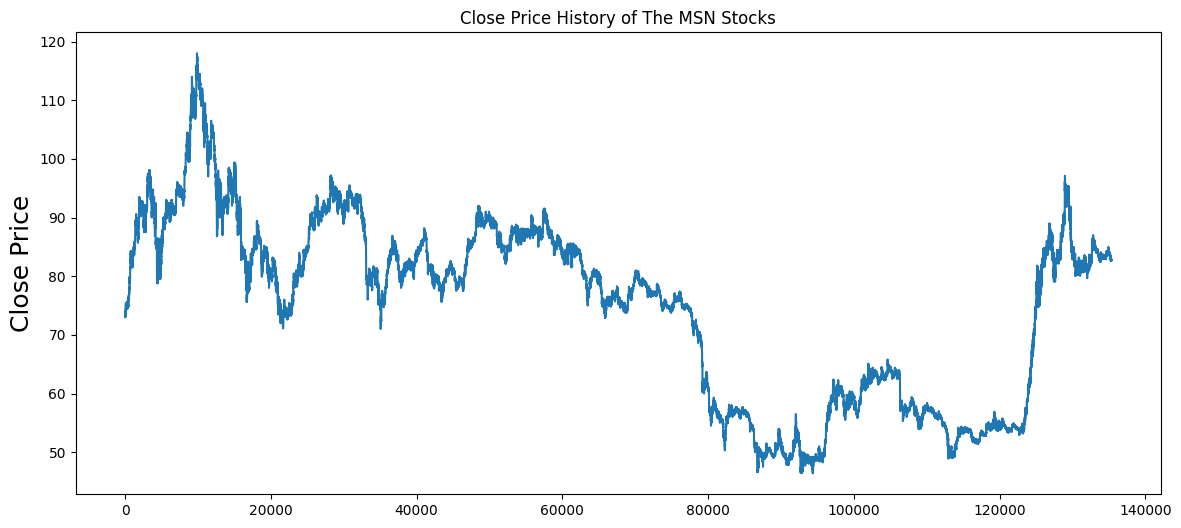

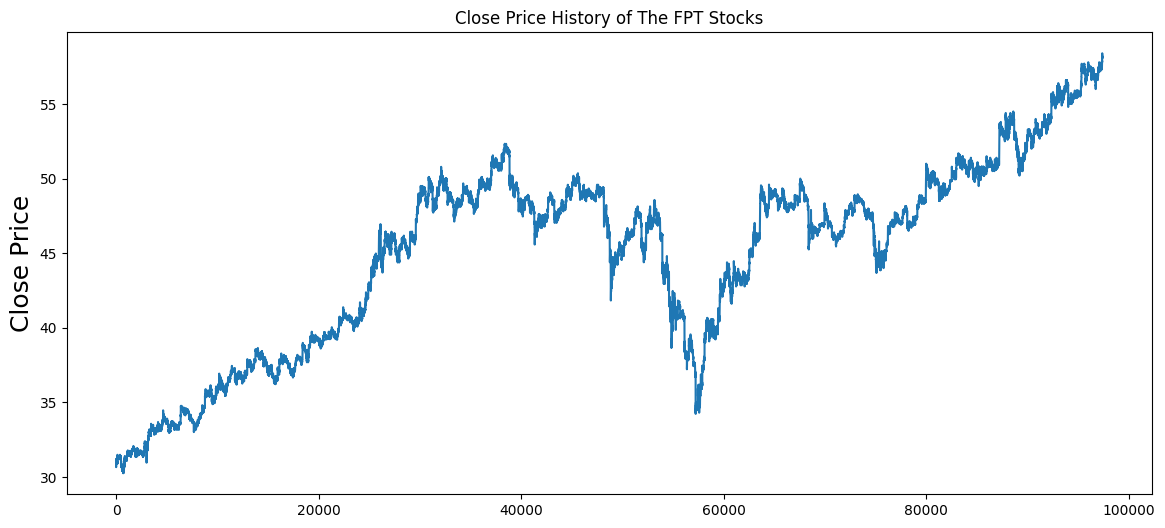

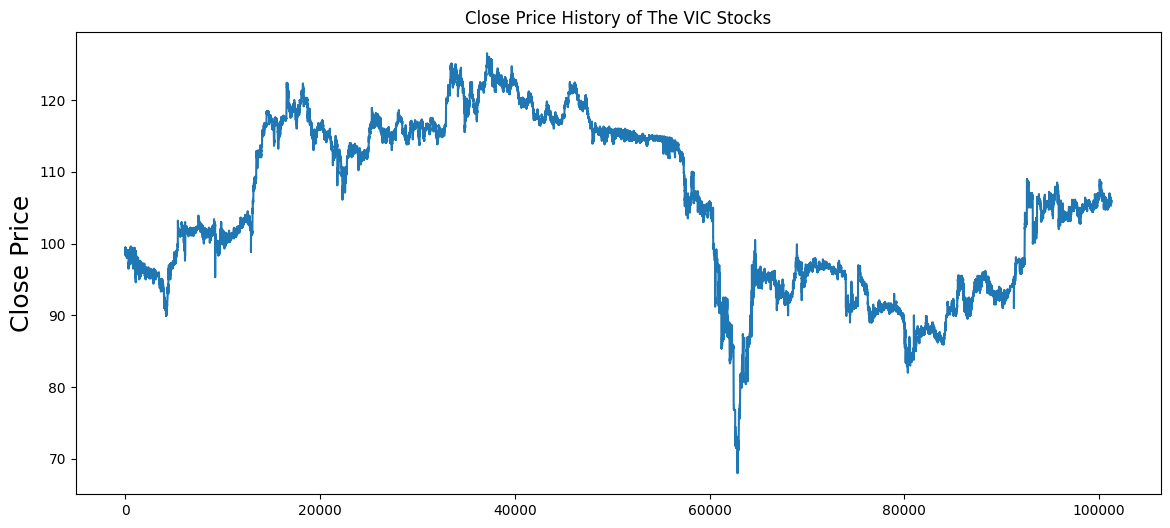

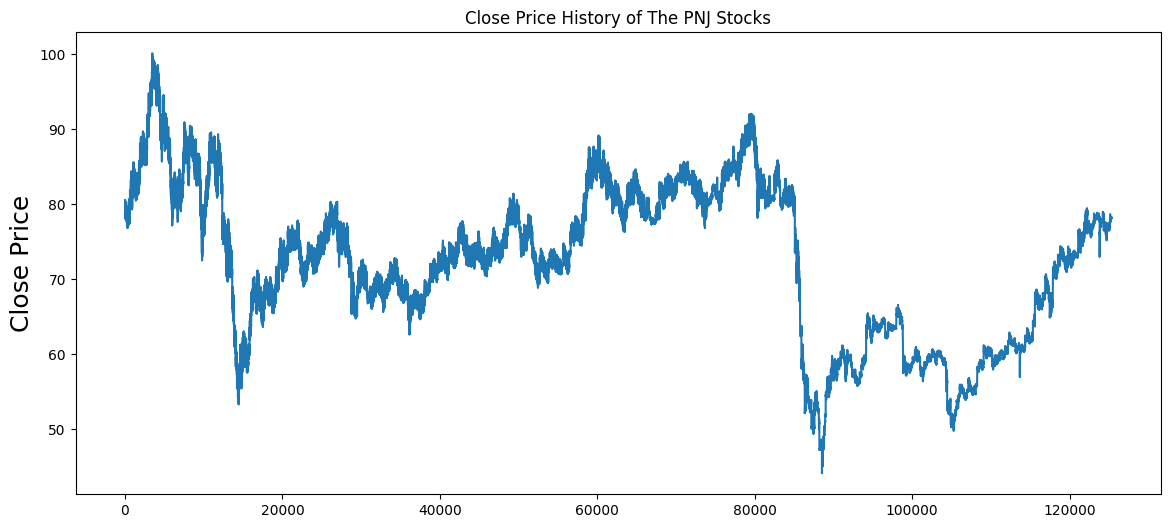

In [64]:
data_dir = "/content/drive/MyDrive/Datasets/JewelryCompany"
figsize = (14, 6)
fontsize = 18

dataset = Dataset(data_dir, figsize, fontsize)
paths_df = dataset.open_data()
print("All of paths of data")
print(paths_df)
print("-"*50)
print("Dataframe of all ticker stocks")
df = dataset.merging_data(paths_df)
display(df)
print("-"*50)
dataset.show_info(df)
dataset.show_plot_all_ticker(df)




#### Data Processing


In [65]:
def data_processing(df):
  df_processing = df.copy()
  print("Drop Open Interest Column...")
  df_processing = df_processing.drop(columns=["Open Interest"]) # because Open Interest column only 0 ==> create not need for training

  # Sort data by Ticker and Date/Time
  df_processing = df_processing.sort_values(by=['Ticker', 'Date/Time'])

  print("-"*50)
  # ## fillna if they exist in data.
  # print("Check NA values and...")
  # df_processing.fillna(0, inplace=True)
  # print(df_processing.isnull().sum())
  # print("-"*50)


  # convert Date/Time contribution into datetime column (original type of it is object)
  df_processing["Date/Time"] = pd.to_datetime(df_processing["Date/Time"])
  print(df_processing.info())
  print("-"*50)

  # Drop NA values
  print("Completing drop NA values...")
  df_processing.dropna(inplace=True)
  print(df_processing.isnull().sum())
  print("-"*50)
  return df_processing

In [66]:
data_processing = data_processing(df)


Drop Open Interest Column...
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 459335 entries, 1221 to 86366
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     459335 non-null  object        
 1   Date/Time  459335 non-null  datetime64[ns]
 2   Open       459335 non-null  float64       
 3   High       459335 non-null  float64       
 4   Low        459335 non-null  float64       
 5   Close      459335 non-null  float64       
 6   Volume     459335 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 28.0+ MB
None
--------------------------------------------------
Completing drop NA values...
Ticker       0
Date/Time    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64
--------------------------------------------------


#### Feature Engineering

In [69]:
# N = 1 # number of days to predict (1 minutes for each data point)

def extract_features(df, N: int):

  ## create a column to show daily volatility of stocks price.
  df["Range"] = df["High"] - df["Low"]

  ## moving average of the stock price over different time period.
  df["MA_5"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=5).mean())
  df["MA_10"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window=10).mean())
  df["MA_20"] =  df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window = 20).mean())

  ## using std instead of meaning
  df["STD_5"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window = 5).std())
  df["STD_10"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window = 10).std())
  df["STD_20"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(window = 20).std())

  # Price Momentum (PM) of data - Percentage change in the closing price over different periods.
  df["PM_5"] = df.groupby("Ticker")["Close"].transform(lambda x: x.pct_change(periods=5))
  df["PM_10"] = df.groupby("Ticker")["Close"].transform(lambda x: x.pct_change(periods=10))
  df["PM_20"] = df.groupby("Ticker")["Close"].transform(lambda x: x.pct_change(periods=20))

  # Volume Change - The percentage change in volume
  df["VC_5"] = df.groupby("Ticker")["Volume"].transform(lambda x: x.pct_change(periods=5))
  df["VC_10"] = df.groupby("Ticker")["Volume"].transform(lambda x: x.pct_change(periods=10))
  df["VC_20"] = df.groupby("Ticker")["Volume"].transform(lambda x: x.pct_change(periods=20))

  # Bollinger Bands - A volatility indicator based on moving averages.
  df["Upper_Band"] = df["MA_20"] + (df["STD_20"] * 2)
  df["Lower_Band"] = df["MA_20"] - (df["STD_20"] * 2)

  # Time Features - divide into 4 columns such as hour, day, month, minute
  df["Hour"] = df["Date/Time"].dt.hour
  df["Day"] = df["Date/Time"].dt.day
  df["Month"] = df["Date/Time"].dt.month
  df["Minute"] = df["Date/Time"].dt.minute

  ### extract target value - Stock Price Volatility
  df["Future_Close"] = df.groupby("Ticker")["Close"].shift(-N)
  df["Target"] = df["Future_Close"] - df["Close"]
  df.dropna(subset=['Future_Close', 'Target'],inplace = True)



  df = df.sort_values(by=['Ticker', 'Date/Time'])
  ## choose numerous important features for training model.
  feature_columns = ['Date/Time', 'Ticker', 'Target', 'Open',  'Volume',
       'Range', 'PM_20', 'VC_20', 'Upper_Band', 'Lower_Band']
  df = df[feature_columns]

  # Replace infinite values with NaN
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  # Drop rows with NaN values
  # df.dropna(subset=['PM_20', 'VC_20', 'Upper_Band', 'Lower_Band', 'Target'],inplace = True)


  # Normalize some features
  scaler = MinMaxScaler(feature_range=(0,1))
  columns_scale =  ['Target','Volume','Range', 'PM_20', 'VC_20', 'Upper_Band', 'Lower_Band']
  df[columns_scale] = scaler.fit_transform(df[columns_scale])
  df.set_index("Date/Time", inplace=True)
  # df.reset_index(inplace=True)

  return df



In [70]:
df_final = extract_features(data_processing, N=60)
df_final

,Ticker,Target,Open,Volume,Range,PM_20,VC_20,Upper_Band,Lower_Band
Date/Time,,,,,,,,,
2018-12-25 09:15:00,FPT,0.648120,30.89,0.010728,0.000000,0.106880,1.200093e-04,0.197085,0.257424
2018-12-25 09:16:00,FPT,0.648734,30.81,0.000057,0.000000,0.105390,5.175048e-07,0.213642,0.224891
2018-12-25 09:17:00,FPT,0.649271,30.74,0.000339,0.009722,0.103946,1.585311e-05,0.223102,0.199830
2018-12-25 09:18:00,FPT,0.649271,30.74,0.000642,0.000000,0.103946,6.430172e-06,0.228480,0.179145
2018-12-25 09:19:00,FPT,0.648580,30.74,0.006816,0.000000,0.103946,2.707073e-03,0.231007,0.161519
...,...,...,...,...,...,...,...,...,...
2020-12-22 14:22:00,VIC,0.576362,105.80,0.000566,0.013889,0.298586,2.699847e-05,0.608073,0.827524
2020-12-22 14:23:00,VIC,0.576362,105.70,0.000760,0.000000,0.298586,1.811933e-04,0.608137,0.827284
2020-12-22 14:24:00,VIC,0.576362,105.70,0.001096,0.000000,0.298586,1.347017e-05,0.608171,0.827074


#### Modeling
  - Split dataset
  - Use some suitable models

- create 2 datasets from the final dataset.

In [71]:
df_final.iloc[:, 2:]

,Open,Volume,Range,PM_20,VC_20,Upper_Band,Lower_Band
Date/Time,,,,,,,
2018-12-25 09:15:00,30.89,0.010728,0.000000,0.106880,1.200093e-04,0.197085,0.257424
2018-12-25 09:16:00,30.81,0.000057,0.000000,0.105390,5.175048e-07,0.213642,0.224891
2018-12-25 09:17:00,30.74,0.000339,0.009722,0.103946,1.585311e-05,0.223102,0.199830
2018-12-25 09:18:00,30.74,0.000642,0.000000,0.103946,6.430172e-06,0.228480,0.179145
2018-12-25 09:19:00,30.74,0.006816,0.000000,0.103946,2.707073e-03,0.231007,0.161519
...,...,...,...,...,...,...,...
2020-12-22 14:22:00,105.80,0.000566,0.013889,0.298586,2.699847e-05,0.608073,0.827524
2020-12-22 14:23:00,105.70,0.000760,0.000000,0.298586,1.811933e-04,0.608137,0.827284
2020-12-22 14:24:00,105.70,0.001096,0.000000,0.298586,1.347017e-05,0.608171,0.827074


In [72]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_final.iloc[:, 2:] = imputer.fit_transform(df_final.iloc[:, 2:])

X = df_final.iloc[:, 2:]
y = df_final["Target"]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
TRAIN_SIZE = int(len(X) * 0.8)
TEST_SIZE = len(X) - TRAIN_SIZE
print(f"TRAIN_SIZE: {TRAIN_SIZE}")
print(f"TEST_SIZE: {TEST_SIZE}")
train_df_final = df_final.iloc[:TRAIN_SIZE]
test_df_final = df_final.iloc[TRAIN_SIZE:]

X_train, X_test, y_train, y_test = X[:TRAIN_SIZE], X[TRAIN_SIZE:], y[:TRAIN_SIZE], y[TRAIN_SIZE:]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")




Shape of X: (458855, 7)
Shape of y: (458855,)
TRAIN_SIZE: 367084
TEST_SIZE: 91771
Shape of X_train: (367084, 7)
Shape of y_train: (367084,)
Shape of X_test: (91771, 7)
Shape of y_test: (91771,)


In [73]:

print(f"Shape of train_df_final: {train_df_final.shape}")
print(f"Shape of test_df_final: {test_df_final.shape}")

Shape of train_df_final: (367084, 9)
Shape of test_df_final: (91771, 9)


In [75]:
train_df_final.iloc[:, 1:]

,Target,Open,Volume,Range,PM_20,VC_20,Upper_Band,Lower_Band
Date/Time,,,,,,,,
2018-12-25 09:15:00,0.648120,30.89,0.010728,0.000000,0.106880,1.200093e-04,0.197085,0.257424
2018-12-25 09:16:00,0.648734,30.81,0.000057,0.000000,0.105390,5.175048e-07,0.213642,0.224891
2018-12-25 09:17:00,0.649271,30.74,0.000339,0.009722,0.103946,1.585311e-05,0.223102,0.199830
2018-12-25 09:18:00,0.649271,30.74,0.000642,0.000000,0.103946,6.430172e-06,0.228480,0.179145
2018-12-25 09:19:00,0.648580,30.74,0.006816,0.000000,0.103946,2.707073e-03,0.231007,0.161519
...,...,...,...,...,...,...,...,...
2019-01-02 13:20:00,0.509593,100.00,0.000272,0.000000,0.297448,4.060536e-06,0.561883,0.776362
2019-01-02 13:21:00,0.508826,100.00,0.000530,0.000000,0.297448,1.885516e-05,0.561207,0.776742
2019-01-02 13:22:00,0.506523,100.00,0.000575,0.000000,0.297448,1.371583e-04,0.560092,0.777593


In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459095 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Ticker      459095 non-null  object 
 1   Target      459095 non-null  float64
 2   Open        459095 non-null  float64
 3   Volume      459095 non-null  int64  
 4   Range       459095 non-null  float64
 5   PM_20       459095 non-null  float64
 6   VC_20       459095 non-null  float64
 7   Upper_Band  459095 non-null  float64
 8   Lower_Band  459095 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 35.0+ MB


In [76]:

# convert an array of values into a dataset matrix for applying LSTM model
def create_dataset_lstm(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


In [77]:
X_train_lstm, y_train_lstm = create_dataset_lstm(train_df_final.iloc[:,1:].values, time_step=100)
X_test_lstm, y_test_lstm = create_dataset_lstm(test_df_final.iloc[:,1:].values, time_step=100)

print(f"Types of dataset for applying in LSTM model")
print(f"Shape of X_train: {X_train_lstm.shape}")
print(f"Shape of y_train: {y_train_lstm.shape}")
print(f"Shape of X_test: {X_test_lstm.shape}")
print(f"Shape of y_test: {y_test_lstm.shape}")

Types of dataset for applying in LSTM model
Shape of X_train: (366983, 100)
Shape of y_train: (366983,)
Shape of X_test: (91670, 100)
Shape of y_test: (91670,)


### Building numerous models

- XGBoost Model

In [32]:
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_train,y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Neural Networks

In [16]:
from sklearn.neural_network import MLPRegressor
model_mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)
model_mlp.fit(X_train, y_train)


MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)

- LSTM model

In [161]:
class LSTM(nn.Module):
    def __init__(self,
                 input_size: int = 1,
                 hidden_layer_size: int = 100,
                 output_size: int = 1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)  # Use batch_first=True
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq, hidden_cell):
        # input_seq: (batch_size, seq_len, input_size) expected
        lstm_out, hidden_cell = self.lstm(input_seq, hidden_cell)  # LSTM output
        print(lstm_out.shape)
        predictions = self.linear(lstm_out[:, -1, :])  # Use the last time step for prediction
        # return lstm_out, hidden_cell
        return predictions, hidden_cell

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_layer_size).to(device),
                torch.zeros(1, batch_size, self.hidden_layer_size).to(device))



In [162]:
class LSTM_ImprovedModel(nn.Module):
    def __init__(self,
                 input_size: int = 1,
                 hidden_layer_size: int = 100,
                 output_size: int = 1,
                 dropout_prob: float = 0.2):

        super(LSTM_ImprovedModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm1 = LSTM(input_size=input_size,
                          hidden_layer_size=hidden_layer_size,
                          output_size=output_size)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.lstm2 = LSTM(input_size=input_size,
                          hidden_layer_size=hidden_layer_size,
                          output_size=output_size)
        self.dropout2 = nn.Dropout(dropout_prob + 0.1)

        self.lstm3 = LSTM(input_size=input_size,
                  hidden_layer_size=hidden_layer_size,
                  output_size=output_size)
        self.dropout3 = nn.Dropout(dropout_prob + 0.2)

        self.lstm4 = LSTM(input_size=input_size,
                  hidden_layer_size=hidden_layer_size,
                  output_size=output_size)
        self.dropout4 = nn.Dropout(dropout_prob + 0.3)

        self.fc = nn.Linear(hidden_layer_size, input_size)

    def forward(self, input_seq, hidden_cell):
        # input_seq: (batch_size, seq_len, input_size) expected

        x, hidden_cell = self.lstm1(input_seq, hidden_cell)  # LSTM output
        x = self.dropout1(x)

        x, hidden_cell = self.lstm2(x, hidden_cell)
        x = self.dropout2(x)

        x, hidden_cell = self.lstm3(x, hidden_cell)
        x = self.dropout3(x)

        x, hidden_cell = self.lstm4(x, hidden_cell)
        x = self.dropout4(x)

        predictions = self.fc(x[:, -1, :])  # Use the last time step for prediction

        return predictions, hidden_cell
    def init_hidden(self, batch_size, device):
      # Initialize hidden state and cell state
      return (torch.zeros(1, batch_size, self.hidden_layer_size).to(device),
              torch.zeros(1, batch_size, self.hidden_layer_size).to(device))
    # def init_hidden(self, batch_size, device):
    #     # Initialize hidden states for all LSTM layers with corresponding hidden sizes
    #     return [(torch.zeros(1, batch_size, self.hidden_layer_size).to(device),
    #              torch.zeros(1, batch_size, self.hidden_layer_size).to(device)),

    #             (torch.zeros(1, batch_size, self.hidden_layer_size + 20).to(device),
    #              torch.zeros(1, batch_size, self.hidden_layer_size + 20).to(device)),

    #             (torch.zeros(1, batch_size, self.hidden_layer_size + 40).to(device),
    #              torch.zeros(1, batch_size, self.hidden_layer_size + 40).to(device)),

    #             (torch.zeros(1, batch_size, self.hidden_layer_size + 60).to(device),
    #              torch.zeros(1, batch_size, self.hidden_layer_size + 60).to(device))]

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
input_size = 1
hidden_layer_size = 100
output_size = batch_size
dropout_prob = 0.2
# lstm = LSTM(input_size = input_size, hidden_layer_size = hidden_layer_size, output_size = output_size)
improved_lstm = LSTM_ImprovedModel(input_size = input_size,
                                   hidden_layer_size = hidden_layer_size,
                                   output_size = output_size,
                                   dropout_prob = dropout_prob)
improved_lstm = improved_lstm.to(device)
for name, param in improved_lstm.named_parameters():
  print(name, param.shape)
  print("-"*50)

epochs = 5
time_step = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(improved_lstm.parameters(), lr=0.001)


lstm1.lstm.weight_ih_l0 torch.Size([400, 1])
--------------------------------------------------
lstm1.lstm.weight_hh_l0 torch.Size([400, 100])
--------------------------------------------------
lstm1.lstm.bias_ih_l0 torch.Size([400])
--------------------------------------------------
lstm1.lstm.bias_hh_l0 torch.Size([400])
--------------------------------------------------
lstm1.linear.weight torch.Size([32, 100])
--------------------------------------------------
lstm1.linear.bias torch.Size([32])
--------------------------------------------------
lstm2.lstm.weight_ih_l0 torch.Size([400, 1])
--------------------------------------------------
lstm2.lstm.weight_hh_l0 torch.Size([400, 100])
--------------------------------------------------
lstm2.lstm.bias_ih_l0 torch.Size([400])
--------------------------------------------------
lstm2.lstm.bias_hh_l0 torch.Size([400])
--------------------------------------------------
lstm2.linear.weight torch.Size([32, 100])
---------------------------

In [96]:
## Create Data Loader

# Convert the X_train_lstm array to a numeric data type, for example float32
X_train_lstm = X_train_lstm.astype(np.float32)

# Convert the array to a PyTorch tensor and move it to the device
X_train_lstm = torch.tensor(X_train_lstm, dtype=torch.float32).to(device)
# X_train_lstm = torch.tensor(X_train_lstm, dtype=torch.float32).to(device)
y_train_lstm = torch.tensor(y_train_lstm, dtype=torch.float32).to(device)

print(f"Shape of X_train: {X_train_lstm.shape}")
print(f"Shape of y_train: {y_train_lstm.shape}")
train_data = TensorDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False, )


AttributeError: 'Tensor' object has no attribute 'astype'

In [164]:
def train(lstm, device, train_loader, optimizer,loss_function, epoch, batch_size):
  lstm.train()

  for epoch in range(epochs):
      # hidden_cell = lstm.init_hidden(batch_size, device)  # Reset hidden state at the beginning of each epoch

      for i, (X_lstm, y_lstm) in enumerate(train_loader):
          X_lstm, y_lstm = X_lstm.to(device), y_lstm.to(device)

          # print(f"Shape of X_lstm: {X_lstm.shape}")
          # print(f"Shape of y_lstm: {y_lstm.shape}")

          # Clear gradients
          optimizer.zero_grad()

          # Dynamically get the current batch size (may be different for the last batch)
          batch_size = X_lstm.shape[0]

          # Initialize hidden state for the current batch size
          hidden_cell = lstm.init_hidden(batch_size, device)

          # Reshape input to (batch_size, sequence_length, input_size)
          x_train_lstm = X_lstm.view(batch_size, 100, 1)  # Assume sequence length is 100, and input size is 1

          # Forward pass, using the updated hidden cell
          y_train_pred, hidden_cell = lstm(x_train_lstm, hidden_cell)

          # Detach hidden state to prevent backprop through entire sequence history
          hidden_cell = (hidden_cell[0].detach(), hidden_cell[1].detach())

          # Ensure y_train_pred and y_lstm have the same shape
          y_train_pred = y_train_pred.view(batch_size, -1)  # Flatten predictions
          y_lstm = y_lstm.view(batch_size, -1)  # Ensure targets have same shape

          loss = loss_function(y_train_pred, y_lstm)  # Compute loss on last prediction
          loss.backward()
          optimizer.step()

      print(f"Epoch: {epoch}, Loss: {loss.item()}")

  return model


In [165]:
lstm_model = train(improved_lstm, device, train_loader, optimizer,loss_function, epochs, batch_size)
lstm_model

torch.Size([32, 100, 100])


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 100

In [ ]:
### evaluation LSTM model
def evaluation_lstm(model, X_test, y_test):
  model.eval()
  hidden_cell = model.init_hidden(device)
  with torch.no_grad():
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    y_pred = []
    for i in range(X_test.shape[0]):
      x_test = X_test[i]
      y_test_item = y_test[i]
      x_test = x_test.view(100, 1, 1)
      y_test_pred, hidden_cell = model(x_test, hidden_cell)
      y_pred.append(y_test_pred[-1].item())
      hidden_cell = (hidden_cell[0].detach(), hidden_cell[1].detach())
    y_pred = np.array(y_pred)
    mse = mean_squared_error(y_test, y_pred
                             )
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse,  mae, r2




#### Predict And Evaluation

In [45]:
def mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    """
    ape = np.abs((y_true - y_pred) / y_true)
    ape[~np.isfinite(ape)] = 1
    return np.mean(ape)

def wmape(y_true, y_pred):
    """
    Calculate the Weighted Mean Absolute Percentage Error (WMAPE).
    """
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


In [46]:
def evaluation(model, X_test, y_test):
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mape_value = mape(y_test, y_pred)
  wmape_value = wmape(y_test, y_pred)
  return y_pred, mse, rmse,  mae, r2, mape_value, wmape_value

In [47]:
def show_evaluation(model, name_model, X_test, y_test):
  y_pred, mse, rmse, mae, r2, mape_value, wmape_value = evaluation(model, X_test, y_test)
  print(f"Name of model: {name_model}")
  print(f"Mean Squared Error: {mse}")
  print(f"Root Mean Squared Error: {rmse}")
  print(f"Mean Absolute Error: {mae}")
  print(f"R-squared: {r2}")
  print(f"Mean Absolute Percentage Error: {mape_value}")
  print(f"Weighted Mean Absolute Percentage Error: {wmape_value}")
  return y_pred



In [48]:
y_preds = {}
for model, name_model in zip([model_xgb, model_mlp, lstm], ["XGBoost", "Neural Networks", "LSTM"]):
  if name_model == "LSTM":
    mse, rmse, mae, r2 = evaluation_lstm(model, X_test_lstm, y_test_lstm)
    print("-"*50)
  else:
    y_pred = show_evaluation(model, name_model, X_test, y_test)
    y_preds[name_model] = y_pred
    print("-"*50)

Name of model: XGBoost
Mean Squared Error: 157.9124113341543
Root Mean Squared Error: 12.56632051692755
Mean Absolute Error: 9.032514605594013
Mean Absolute Percentage Error: 13.758094915593844
Weighted Mean Absolute Percentage Error: 1.5638571610392384
--------------------------------------------------
Name of model: Neural Networks
Mean Squared Error: 156.01729530288645
Root Mean Squared Error: 12.490688343837839
Mean Absolute Error: 9.965407290083814
Mean Absolute Percentage Error: 17.98421959041762
Weighted Mean Absolute Percentage Error: 1.7253748522718615
--------------------------------------------------


NameError: name 'evaluation_lstm' is not defined

In [ ]:
y_preds

In [ ]:
scaler_scale = scaler.scale_
scale_factor = 1/scaler_scale[0]
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor


In [ ]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
show_evaluation(model_xgb, "XGBoost", X_test_dataset, y_test_dataset)


In [ ]:
test_df_final

In [ ]:
# data = test_df_final.copy()
# data_new = np.c_[data, y_preds["XGBoost"]]
# # data.reset_index(inplace=True)
# name_columns = data.columns.tolist() + ["Predicted_Volatility"]
# print(name_columns)
# data_new = pd.DataFrame(data_new, columns=name_columns)
# data_new

In [ ]:
data = test_df_final.copy()
data["Predicted_Volatility"] = y_preds["XGBoost"]
data.reset_index(inplace=True)
data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = test_df_final.copy()
data["Predicted_Volatility"] = y_preds["XGBoost"]
data.reset_index(inplace=True)
# Assuming you have 'actual' and 'predicted' values along with 'Date/Time'
plt.figure(figsize=(12, 6))

plt.plot(data['Date/Time'], data['Target'], label='Actual Volatility', color='blue')
plt.plot(data['Date/Time'], data['Predicted_Volatility'], label='Predicted Volatility', color='red', linestyle='--')

plt.title('Actual vs Predicted Stock Price Volatility')
plt.xlabel('Date/Time')
plt.ylabel('Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

#### In Conclusion